In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
from collections import Counter

# Machine learning imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           roc_auc_score, precision_recall_curve, f1_score, roc_curve,
                           balanced_accuracy_score, mean_absolute_error, r2_score)

# For neural networks (later)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set display options
pd.set_option('display.max_columns', None)

In [2]:
# Load the hypertension dataset
# Adjust file path if necessary
df = pd.read_csv('C:\TFM\CODE\HTN Adherence Data.csv')

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Number of patients: {df['MEMBER'].nunique()}")

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\IKERGUNE1\AppData\Local\Temp\ipykernel_21808\3404745311.py:3: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv('C:\TFM\CODE\HTN Adherence Data.csv')


Dataset loaded with 218816 rows and 41 columns
Number of patients: 15912


C:\Users\IKERGUNE1\AppData\Local\Temp\ipykernel_21808\3404745311.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\TFM\CODE\HTN Adherence Data.csv')


# 2. Preprocessing and Feature Engineering

Now, let's preprocess the data and create patient-level features:

In [3]:
# Convert date columns to datetime format
date_columns = ['SERVICE DATE', 'ASSESS DATE', 'DATE RECEIVED', 'BIRTHDATE']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

# Create patient-level features
def create_patient_features(df):
    # Group by patient
    patient_groups = df.groupby('MEMBER')
    
    # Basic demographic and adherence info
    patient_df = patient_groups.agg({
        'ADHERENCE': 'first',
        'GENDER': 'first',
        'CURRENT AGE': 'first',
        'OPTION NAME': 'first'
    }).rename(columns={'CURRENT AGE': 'AGE'})
    
    # Medical characteristics
    patient_df['UNIQUE_MEDS'] = patient_groups['CODE DESCRIPTION'].nunique()
    
    # Classify medications for hypertension
    def classify_medication(description):
        if pd.isna(description):
            return 'Unknown'
        description = description.upper()
        # Adjust these based on hypertension medications
        if any(x in description for x in ['ENALAPRIL', 'LISINOPRIL', 'RAMIPRIL', 'PERINDOPRIL']):
            return 'ACE_Inhibitor'
        elif any(x in description for x in ['LOSARTAN', 'VALSARTAN', 'CANDESARTAN', 'IRBESARTAN']):
            return 'ARB'
        elif any(x in description for x in ['AMLODIPINE', 'NIFEDIPINE', 'FELODIPINE']):
            return 'CCB'  # Calcium channel blockers
        elif any(x in description for x in ['HYDROCHLOROTHIAZIDE', 'CHLORTHALIDONE', 'INDAPAMIDE']):
            return 'Diuretic'
        elif any(x in description for x in ['ATENOLOL', 'METOPROLOL', 'BISOPROLOL', 'CARVEDILOL']):
            return 'Beta_Blocker'
        else:
            return 'Other'
    
    df['MED_CLASS'] = df['CODE DESCRIPTION'].apply(classify_medication)
    med_classes = patient_groups['MED_CLASS'].apply(set).apply(list)
    
    # Create medication class indicators
    for med_class in ['ACE_Inhibitor', 'ARB', 'CCB', 'Diuretic', 'Beta_Blocker', 'Other']:
        patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
            lambda x: int((x['MED_CLASS'] == med_class).any())).values
    
    # Calculate financial patterns
    patient_df['AVG_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].mean()
    patient_df['TOTAL_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].sum()
    patient_df['NUM_CLAIMS'] = patient_groups.size()
    patient_df['AVG_UNITS'] = patient_groups['UNITS'].mean()
    
    # Calculate refill patterns
    def get_refill_stats(group):
        if len(group) <= 1:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0
            })

        # Sort by date and calculate days between refills
        sorted_dates = group['SERVICE DATE'].sort_values()
        days_between = (sorted_dates.diff().dt.days.dropna())
        
        if len(days_between) == 0:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0
            })
            
        avg_gap = days_between.mean()
        max_gap = days_between.max()
        
        # Coefficient of variation for regularity
        regularity = days_between.std() / avg_gap if avg_gap > 0 else 0
        
        return pd.Series({
            'AVG_DAYS_BETWEEN_REFILLS': avg_gap,
            'MAX_GAP': max_gap,
            'REFILL_REGULARITY': regularity
        })
    
    refill_stats = patient_groups.apply(get_refill_stats)
    patient_df = pd.concat([patient_df, refill_stats], axis=1)
    
    # Add healthcare plan information
    plan_types = {
        'BASICARE': {'TYPE': 'STANDARD', 'COST': 'LOW'},
        'ICARE': {'TYPE': 'STANDARD', 'COST': 'MEDIUM'},
        'STUDYMATE PRIVATE': {'TYPE': 'SPECIAL', 'COST': 'LOW'},
        'PRIVATE HOSPITAL': {'TYPE': 'PREMIUM', 'COST': 'HIGH'},
        'PRIVATE HOSPITAL PLUS': {'TYPE': 'PREMIUM', 'COST': 'HIGH'}
    }
    
    patient_df['PLAN_TYPE'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('TYPE', 'STANDARD'))
    patient_df['PLAN_COST'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('COST', 'MEDIUM'))
    
    # Create adherence categories
    patient_df['ADHERENCE_BINARY'] = (patient_df['ADHERENCE'] >= 7).astype(int)  # 7+ is considered adherent
    
    # Create 3-class adherence
    def adherence_category(score):
        if score <= 4:
            return 0  # 'Low'
        elif score <= 8:
            return 1  # 'Medium'
        else:
            return 2  # 'High'
            
    patient_df['ADHERENCE_CATEGORY'] = patient_df['ADHERENCE'].apply(adherence_category)
    
    # Fill missing values
    numeric_cols = patient_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        patient_df[col] = patient_df[col].fillna(patient_df[col].median())
        
    return patient_df

# Create patient-level dataset
patient_df = create_patient_features(df)
print(f"Created patient-level dataset with {patient_df.shape[0]} patients and {patient_df.shape[1]} features")

C:\Users\IKERGUNE1\AppData\Local\Temp\ipykernel_21808\3806193451.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
C:\Users\IKERGUNE1\AppData\Local\Temp\ipykernel_21808\3806193451.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
C:\Users\IKERGUNE1\AppData\Local\Temp\ipyker

Created patient-level dataset with 15912 patients and 22 features


C:\Users\IKERGUNE1\AppData\Local\Temp\ipykernel_21808\3806193451.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  refill_stats = patient_groups.apply(get_refill_stats)


In [5]:
# Display the first few rows of the patient dataset
patient_df.head()

,ADHERENCE,GENDER,AGE,OPTION NAME,UNIQUE_MEDS,TAKES_ACE_INHIBITOR,TAKES_ARB,TAKES_CCB,TAKES_DIURETIC,TAKES_BETA_BLOCKER,TAKES_OTHER,AVG_CLAIM_AMOUNT,TOTAL_CLAIM_AMOUNT,NUM_CLAIMS,AVG_UNITS,AVG_DAYS_BETWEEN_REFILLS,MAX_GAP,REFILL_REGULARITY,PLAN_TYPE,PLAN_COST,ADHERENCE_BINARY,ADHERENCE_CATEGORY
MEMBER,,,,,,,,,,,,,,,,,,,,,,
92222365,1,F,48,PRIVATE HOSPITAL PLUS,1,0,1,0,0,0,0,21435.440000,21435.44,1,28.000000,0.000000,0.0,0.000000,PREMIUM,HIGH,0,0
92222436,7,M,75,PRIVATE HOSPITAL PLUS,5,0,1,1,0,0,1,3684.589444,66322.61,18,31.666667,18.647059,125.0,1.784679,PREMIUM,HIGH,1,1
92222445,2,M,60,PRIVATE HOSPITAL PLUS,3,0,1,1,0,0,1,3010.403333,9031.21,3,16.666667,31.000000,62.0,1.414214,PREMIUM,HIGH,0,0
92222489,11,M,42,PRIVATE HOSPITAL PLUS,1,0,0,0,0,1,0,5830.515000,69966.18,12,28.833333,30.636364,37.0,0.164034,PREMIUM,HIGH,1,2
92222828,7,M,39,PRIVATE HOSPITAL,6,0,1,1,0,0,0,3547.529286,49665.41,14,42.857143,13.846154,39.0,1.150597,PREMIUM,HIGH,1,1


# 3. Prepare Data for Modeling

In [6]:
# Prepare data for modeling
X = patient_df.drop(['ADHERENCE', 'ADHERENCE_BINARY', 'ADHERENCE_CATEGORY'], axis=1)
y_binary = patient_df['ADHERENCE_BINARY']  # Binary classification
y_multiclass = patient_df['ADHERENCE_CATEGORY']  # 3-class classification
y_full = patient_df['ADHERENCE']  # Full regression/classification

# Identify feature types
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Boolean (integer) features (keeping as numeric)
binary_features = [col for col in numeric_features if col.startswith('TAKES_')]
# Remove binary features from numeric features list to handle them separately
numeric_features = [col for col in numeric_features if col not in binary_features]

# Print feature information
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Binary features: {len(binary_features)}")

# Split data for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.25, random_state=42, stratify=y_binary
)

# Split data for 3-class
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.25, random_state=42, stratify=y_multiclass
)

# Split data for full regression/classification
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y_full, test_size=0.25, random_state=42
)

print(f"Training set size: {X_train_bin.shape[0]}, Test set size: {X_test_bin.shape[0]}")

Numeric features: 9
Categorical features: 4
Binary features: 6
Training set size: 11934, Test set size: 3978


# 4. Create Preprocessing Pipeline

In [7]:
# Create a preprocessing pipeline that properly handles all feature types
# Function to convert boolean to int
def bool_to_int(X):
    return X.astype(int)

# Create preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline(steps=[
    ('to_int', FunctionTransformer(bool_to_int, validate=False)),  # Convert bool to int
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

# 5. Binary Classification Models


======== BINARY CLASSIFICATION ========
Training Random Forest classifier...
Training SVM classifier...
Best RF parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best SVM parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1917
           1       0.91      0.96      0.94      2061

    accuracy                           0.93      3978
   macro avg       0.93      0.93      0.93      3978
weighted avg       0.93      0.93      0.93      3978

ROC AUC: 0.9750

SVM Performance:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1917
           1       0.93      0.95      0.94      2061

    accuracy                           0.94      3978
   macro avg   

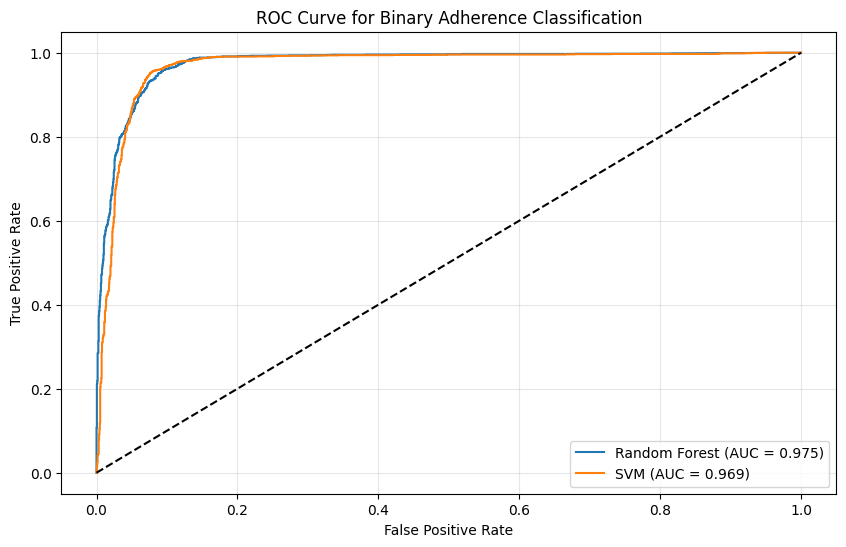

In [8]:
print("\n======== BINARY CLASSIFICATION ========")

# Create pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Define parameter grids
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced']
}

svm_param_grid = {
    'classifier__C': [0.1, 1],
    'classifier__gamma': ['scale'],
    'classifier__class_weight': ['balanced']
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train Random Forest
print("Training Random Forest classifier...")
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(X_train_bin, y_train_bin)

# Train SVM (with smaller parameter grid)
print("Training SVM classifier...")
svm_grid = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
svm_grid.fit(X_train_bin, y_train_bin)

# Print best parameters
print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best SVM parameters: {svm_grid.best_params_}")

# Evaluate models
y_pred_rf = rf_grid.predict(X_test_bin)
y_prob_rf = rf_grid.predict_proba(X_test_bin)[:, 1]

y_pred_svm = svm_grid.predict(X_test_bin)
y_prob_svm = svm_grid.predict_proba(X_test_bin)[:, 1]

# Print metrics
print("\nRandom Forest Performance:")
print(classification_report(y_test_bin, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test_bin, y_prob_rf):.4f}")

print("\nSVM Performance:")
print(classification_report(y_test_bin, y_pred_svm))
print(f"ROC AUC: {roc_auc_score(y_test_bin, y_prob_svm):.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test_bin, y_prob_rf):.3f})')

fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_prob_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test_bin, y_prob_svm):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Adherence Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


======== 3-CLASS CLASSIFICATION ========
Training Random Forest for 3-class classification...
Training SVM for 3-class classification...

Random Forest 3-Class Performance:
              precision    recall  f1-score   support

         Low       0.98      0.87      0.92      1490
      Medium       0.71      0.72      0.72       933
        High       0.83      0.91      0.87      1555

    accuracy                           0.85      3978
   macro avg       0.84      0.83      0.84      3978
weighted avg       0.86      0.85      0.85      3978


SVM 3-Class Performance:
              precision    recall  f1-score   support

         Low       0.97      0.88      0.92      1490
      Medium       0.73      0.82      0.77       933
        High       0.89      0.90      0.89      1555

    accuracy                           0.87      3978
   macro avg       0.86      0.87      0.86      3978
weighted avg       0.88      0.87      0.88      3978



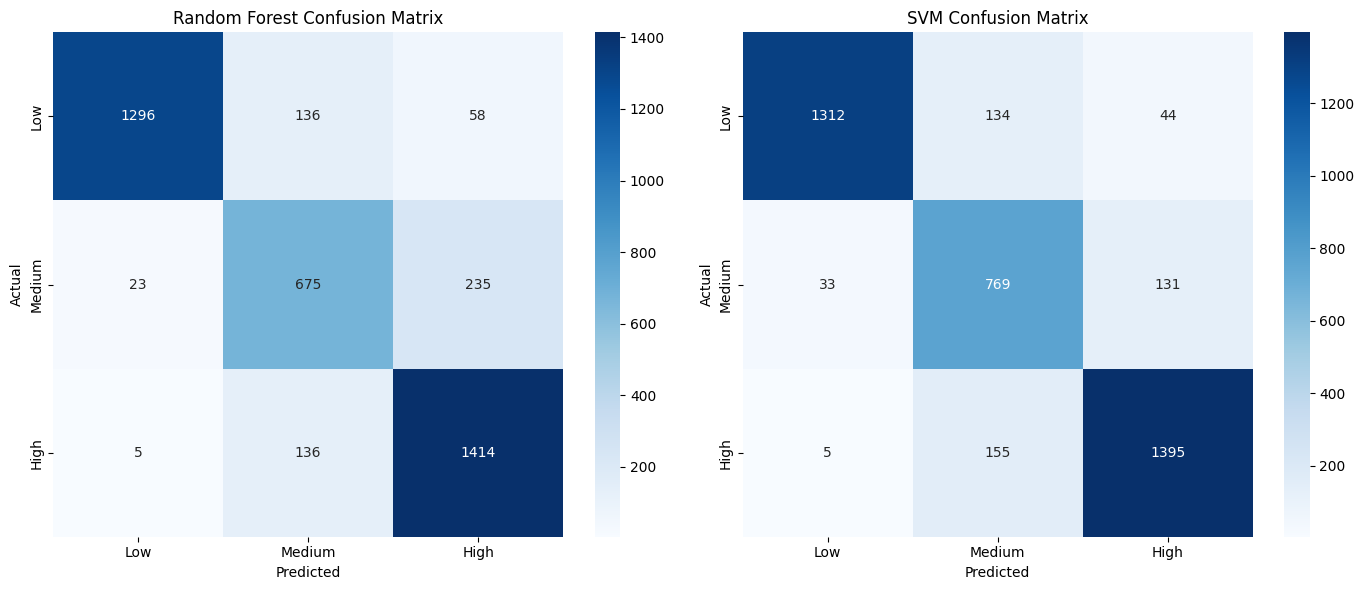

In [9]:
print("\n======== 3-CLASS CLASSIFICATION ========")

# Create pipelines
rf_multi_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

svm_multi_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Use simpler parameter grids for faster execution
rf_multi_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10],
    'classifier__class_weight': ['balanced']
}

svm_multi_param_grid = {
    'classifier__C': [1],
    'classifier__gamma': ['scale'],
    'classifier__class_weight': ['balanced'],
    'classifier__decision_function_shape': ['ovo']
}

# Train Random Forest
print("Training Random Forest for 3-class classification...")
rf_multi_grid = GridSearchCV(
    rf_multi_pipeline,
    rf_multi_param_grid,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)
rf_multi_grid.fit(X_train_multi, y_train_multi)

# Train SVM
print("Training SVM for 3-class classification...")
svm_multi_grid = GridSearchCV(
    svm_multi_pipeline,
    svm_multi_param_grid,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)
svm_multi_grid.fit(X_train_multi, y_train_multi)

# Evaluate models
y_pred_rf_multi = rf_multi_grid.predict(X_test_multi)
y_pred_svm_multi = svm_multi_grid.predict(X_test_multi)

print("\nRandom Forest 3-Class Performance:")
print(classification_report(y_test_multi, y_pred_rf_multi,
                          target_names=['Low', 'Medium', 'High']))

print("\nSVM 3-Class Performance:")
print(classification_report(y_test_multi, y_pred_svm_multi,
                          target_names=['Low', 'Medium', 'High']))

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cm_rf_multi = confusion_matrix(y_test_multi, y_pred_rf_multi)
sns.heatmap(cm_rf_multi, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Low', 'Medium', 'High'],
           yticklabels=['Low', 'Medium', 'High'])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_svm_multi = confusion_matrix(y_test_multi, y_pred_svm_multi)
sns.heatmap(cm_svm_multi, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=['Low', 'Medium', 'High'],
           yticklabels=['Low', 'Medium', 'High'])
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 7. Full 13-Class Classification and Regression Models


======== FULL MULTICLASS MODEL AND REGRESSION ========
Training full multiclass model (13 adherence levels)...
Training regression model...

Full Multiclass Model Performance:
              precision    recall  f1-score   support

           1       0.96      0.88      0.92       730
           2       0.80      0.78      0.79       323
           3       0.54      0.67      0.60       215
           4       0.59      0.36      0.44       236
           5       0.43      0.42      0.42       212
           6       0.50      0.18      0.27       225
           7       0.34      0.31      0.32       186
           8       0.43      0.19      0.26       292
           9       0.40      0.35      0.37       344
          10       0.31      0.30      0.30       370
          11       0.43      0.40      0.42       438
          12       0.37      0.84      0.51       407

    accuracy                           0.53      3978
   macro avg       0.51      0.47      0.47      3978
weighted av

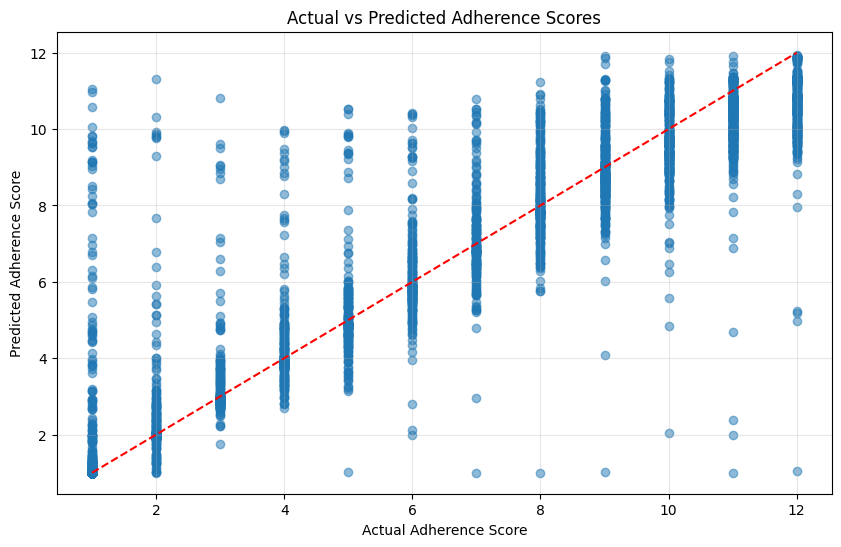

In [ ]:
print("\n======== FULL MULTICLASS MODEL AND REGRESSION ========") #Hay que añadir svm

# Create pipeline for Random Forest
rf_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Create pipeline for regression
rf_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Simple parameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10]
}

reg_param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [10]
}

# Train full multiclass model
print("Training full multiclass model (13 adherence levels)...")
rf_full_grid = GridSearchCV(
    rf_full_pipeline,
    param_grid,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)
rf_full_grid.fit(X_train_full, y_train_full)

# Train regression model
print("Training regression model...")
rf_reg_grid = GridSearchCV(
    rf_reg_pipeline,
    reg_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
rf_reg_grid.fit(X_train_full, y_train_full)

# Evaluate full multiclass model
y_pred_full = rf_full_grid.predict(X_test_full)
print("\nFull Multiclass Model Performance:")
print(classification_report(y_test_full, y_pred_full))

# Evaluate regression model
y_pred_reg = rf_reg_grid.predict(X_test_full)
print("\nRegression Model Performance:")
print(f"R² Score: {r2_score(y_test_full, y_pred_reg):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_full, y_pred_reg):.4f}")

# Plot regression results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_full, y_pred_reg, alpha=0.5)
plt.plot([y_test_full.min(), y_test_full.max()],
         [y_test_full.min(), y_test_full.max()], 'r--')
plt.xlabel('Actual Adherence Score')
plt.ylabel('Predicted Adherence Score')
plt.title('Actual vs Predicted Adherence Scores')
plt.grid(alpha=0.3)
plt.show()

# 8. Feature Importance Analysis


======== FEATURE IMPORTANCE ANALYSIS ========


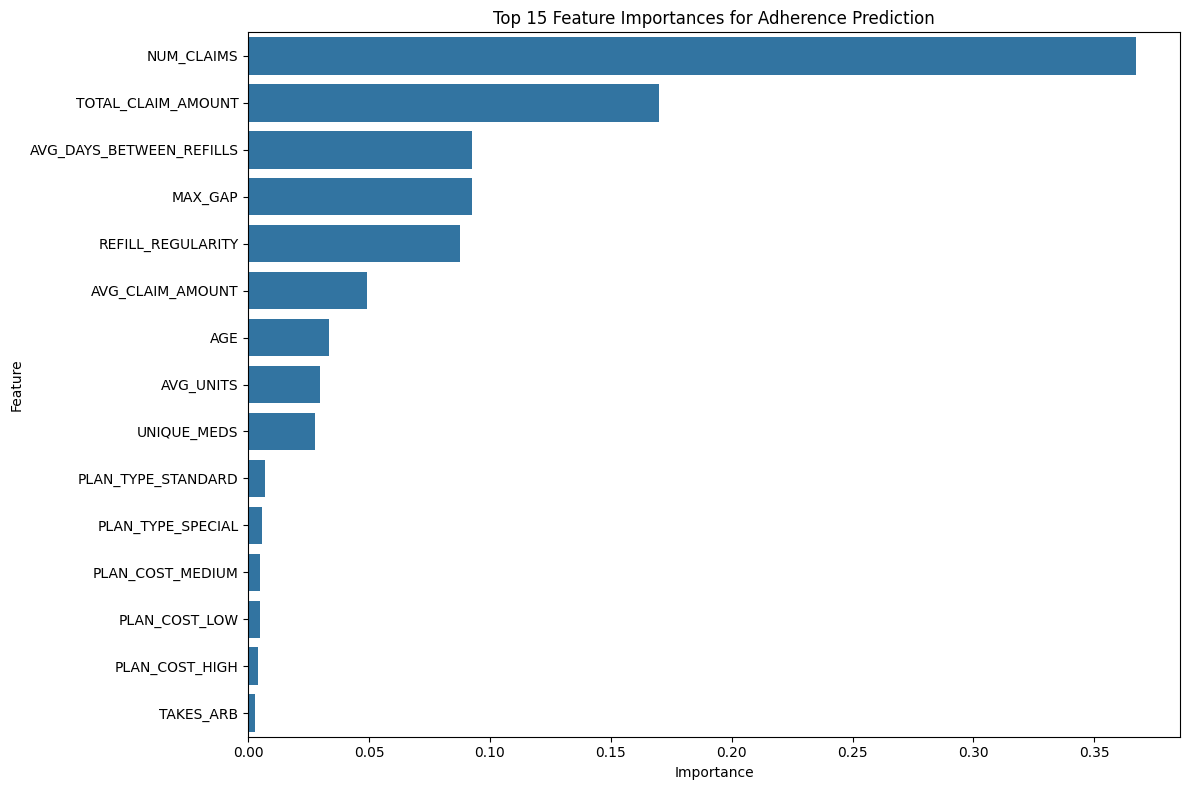

In [11]:
print("\n======== FEATURE IMPORTANCE ANALYSIS ========")

# Get feature names after preprocessing (for numeric and binary features)
feature_names = (
    numeric_features + 
    binary_features + 
    [f"{col}_{val}" for col in categorical_features 
     for val in pd.unique(X[col].dropna())]
)

# Extract feature importances from the Random Forest binary classifier
importances = rf_grid.best_estimator_.named_steps['classifier'].feature_importances_

# Only select the number of features that match the importances array length
if len(feature_names) > len(importances):
    # Get the actual feature names after one-hot encoding
    cat_encoder = rf_grid.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_features = cat_encoder.get_feature_names_out(categorical_features)
        feature_names = numeric_features + binary_features + list(cat_features)
    # If still not matching, just use feature indexes
    if len(feature_names) != len(importances):
        feature_names = [f"Feature {i}" for i in range(len(importances))]

# Create a dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(importances)],
    'Importance': importances
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 15 Feature Importances for Adherence Prediction')
plt.tight_layout()
plt.show()

# 9. Save Models and Create Prediction Function

In [12]:
print("\n======== SAVING MODELS ========")

# Save the best models
joblib.dump(rf_grid.best_estimator_, 'htn_binary_adherence_model.pkl')
joblib.dump(rf_multi_grid.best_estimator_, 'htn_multiclass_adherence_model.pkl')
joblib.dump(rf_reg_grid.best_estimator_, 'htn_regression_adherence_model.pkl')
joblib.dump(preprocessor, 'htn_adherence_preprocessor.pkl')

# Create a prediction function
def predict_adherence(patient_data, model_type='binary'):
    """
    Predict patient adherence using the trained model
    
    Parameters:
    -----------
    patient_data : pandas DataFrame
        Patient data with the same features used in training
    model_type : str, optional (default='binary')
        Type of prediction to make: 'binary', 'multiclass', or 'regression'
        
    Returns:
    --------
    predictions : array
        Predicted adherence class or score
    probabilities : array (only for classification)
        Probability of each class
    """
    if model_type == 'binary':
        model = joblib.load('htn_binary_adherence_model.pkl')
        predictions = model.predict(patient_data)
        probabilities = model.predict_proba(patient_data)
        return predictions, probabilities
    
    elif model_type == 'multiclass':
        model = joblib.load('htn_multiclass_adherence_model.pkl')
        predictions = model.predict(patient_data)
        probabilities = model.predict_proba(patient_data)
        # Convert numeric predictions to categories
        categories = {0: 'Low', 1: 'Medium', 2: 'High'}
        named_predictions = [categories[p] for p in predictions]
        return named_predictions, probabilities
        
    elif model_type == 'regression':
        model = joblib.load('htn_regression_adherence_model.pkl')
        predictions = model.predict(patient_data)
        return predictions, None
        
    else:
        raise ValueError("model_type must be one of 'binary', 'multiclass', or 'regression'")

print("\nModel files saved:")
print("- htn_binary_adherence_model.pkl (adherent vs non-adherent)")
print("- htn_multiclass_adherence_model.pkl (low, medium, high adherence)")
print("- htn_regression_adherence_model.pkl (predicts exact adherence score)")
print("- htn_adherence_preprocessor.pkl (preprocessing pipeline)")
print("\nUse the predict_adherence() function to make predictions on new patient data.")


======== SAVING MODELS ========

Model files saved:
- htn_binary_adherence_model.pkl (adherent vs non-adherent)
- htn_multiclass_adherence_model.pkl (low, medium, high adherence)
- htn_regression_adherence_model.pkl (predicts exact adherence score)
- htn_adherence_preprocessor.pkl (preprocessing pipeline)

Use the predict_adherence() function to make predictions on new patient data.


# 10. Summary of Classical ML Approaches

In [13]:
print("\n======== SUMMARY ========")

# Compare binary classification models
binary_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [accuracy_score(y_test_bin, y_pred_rf), 
                accuracy_score(y_test_bin, y_pred_svm)],
    'ROC AUC': [roc_auc_score(y_test_bin, y_prob_rf),
              roc_auc_score(y_test_bin, y_prob_svm)],
    'F1 Score': [f1_score(y_test_bin, y_pred_rf),
               f1_score(y_test_bin, y_pred_svm)]
})

# Compare multiclass models
multiclass_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [accuracy_score(y_test_multi, y_pred_rf_multi),
               accuracy_score(y_test_multi, y_pred_svm_multi)],
    'Balanced Accuracy': [balanced_accuracy_score(y_test_multi, y_pred_rf_multi),
                        balanced_accuracy_score(y_test_multi, y_pred_svm_multi)],
    'Macro F1': [f1_score(y_test_multi, y_pred_rf_multi, average='macro'),
               f1_score(y_test_multi, y_pred_svm_multi, average='macro')]
})

# Print summaries
print("Binary Classification Performance:")
print(binary_comparison)

print("\n3-Class Classification Performance:")
print(multiclass_comparison)

print("\nRegression Performance:")
print(f"R² Score: {r2_score(y_test_full, y_pred_reg):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_full, y_pred_reg):.4f}")

print("\n======== CONCLUSION ========")
print("1. Key features that predict medication adherence include:")
if 'feature_importance' in locals():
    for i, row in feature_importance.head(5).iterrows():
        print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n2. Model Performance Summary:")
print(f"   - Best binary classification model: {binary_comparison.loc[binary_comparison['ROC AUC'].idxmax(), 'Model']}")
print(f"   - Best multiclass model: {multiclass_comparison.loc[multiclass_comparison['Balanced Accuracy'].idxmax(), 'Model']}")
print(f"   - Regression R² Score: {r2_score(y_test_full, y_pred_reg):.4f}")

print("\n3. Applications:")
print("   - The binary model can identify patients at risk of non-adherence")
print("   - The multiclass model provides more granular risk stratification")
print("   - The regression model gives a precise adherence score prediction")
print("   - These models can support targeted interventions to improve medication adherence for hypertension patients")


======== SUMMARY ========
Binary Classification Performance:
           Model  Accuracy   ROC AUC  F1 Score
0  Random Forest  0.931624  0.974992  0.935758
1            SVM  0.938160  0.969390  0.941092

3-Class Classification Performance:
           Model  Accuracy  Balanced Accuracy  Macro F1
0  Random Forest  0.850930           0.834199  0.835382
1            SVM  0.873806           0.867289  0.863073

Regression Performance:
R² Score: 0.8689
Mean Absolute Error: 0.7967

======== CONCLUSION ========
1. Key features that predict medication adherence include:
   - NUM_CLAIMS: 0.3671
   - TOTAL_CLAIM_AMOUNT: 0.1699
   - AVG_DAYS_BETWEEN_REFILLS: 0.0927
   - MAX_GAP: 0.0925
   - REFILL_REGULARITY: 0.0878

2. Model Performance Summary:
   - Best binary classification model: Random Forest
   - Best multiclass model: SVM
   - Regression R² Score: 0.8689

3. Applications:
   - The binary model can identify patients at risk of non-adherence
   - The multiclass model provides more granular ri

# 11. Neural Network Approach

In [14]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Extract fitted preprocessor from one of your trained models
fitted_preprocessor = rf_grid.best_estimator_.named_steps['preprocessor']

Using device: cuda


Custom Dataset Preparation

In [15]:
class AherenceDataset(Dataset):
    def __init__(self, X, y, task='binary'):
        """
        Convert data to PyTorch tensors
        
        Parameters:
        -----------
        X : preprocessed features
        y : target variable
        task : string, one of 'binary', 'multiclass3', 'multiclass13', 'regression'
        """
        # Apply preprocessor from the existing pipeline
        self.task = task
        self.X = torch.FloatTensor(X)
        
        if task == 'regression':
            self.y = torch.FloatTensor(y.values.reshape(-1, 1))
        else:
            self.y = torch.LongTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to prepare data
def prepare_data_for_nn(X_train, X_test, y_train, y_test, 
                         preprocessor, task='binary', batch_size=32):
    # Apply the same preprocessor from the sklearn pipeline
    X_train_proc = preprocessor.transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    
    # Create datasets
    train_dataset = AherenceDataset(X_train_proc, y_train, task)
    test_dataset = AherenceDataset(X_test_proc, y_test, task)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False
    )
    
    # Get input dimensionality for the model
    input_dim = X_train_proc.shape[1]
    
    return train_loader, test_loader, input_dim

Neural Network Architecture

In [16]:
class AdherenceNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.3, 
                 task='binary'):
        """
        Neural Network for Adherence Prediction
        
        Parameters:
        -----------
        input_dim : int, dimension of input features
        hidden_dims : list, dimensions of hidden layers
        dropout_rate : float, dropout probability
        task : str, one of 'binary', 'multiclass3', 'multiclass13', 'regression'
        """
        super(AdherenceNN, self).__init__()
        
        self.task = task
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))  # Batch normalization
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            
        # Output layer depends on the task
        self.feature_extractor = nn.Sequential(*layers)
        
        # Task-specific output layer
        if task == 'binary':
            self.output_layer = nn.Linear(hidden_dims[-1], 1)
        elif task == 'multiclass3':
            self.output_layer = nn.Linear(hidden_dims[-1], 3)
        elif task == 'multiclass13':
            self.output_layer = nn.Linear(hidden_dims[-1], 13)
        elif task == 'regression':
            self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.output_layer(features)
        
        if self.task == 'binary':
            return outputs.squeeze()
        else:
            return outputs

Training and Evaluation Functions

In [17]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=50, task='binary', 
                valid_loader=None, early_stopping_patience=5):
    """
    Train the neural network model
    
    Parameters:
    -----------
    model : PyTorch model
    train_loader : DataLoader for training data
    criterion : loss function
    optimizer : optimizer
    device : device to train on (cpu or cuda)
    epochs : number of epochs
    task : task type
    valid_loader : optional validation data loader for early stopping
    early_stopping_patience : patience for early stopping
    
    Returns:
    --------
    model : trained model
    history : training history
    """
    model = model.to(device)
    history = {'train_loss': [], 'valid_loss': []}
    best_valid_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            
            # Compute loss
            if task == 'binary':
                loss = criterion(outputs, y_batch.float())
            elif task in ['multiclass3', 'multiclass13']:
                loss = criterion(outputs, y_batch)
            else:  # regression
                loss = criterion(outputs, y_batch)
                
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)
        
        # Validation if provided
        if valid_loader is not None:
            model.eval()
            valid_loss = 0
            valid_batches = 0
            
            with torch.no_grad():
                for X_batch, y_batch in valid_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    
                    outputs = model(X_batch)
                    
                    if task == 'binary':
                        loss = criterion(outputs, y_batch.float())
                    elif task in ['multiclass3', 'multiclass13']:
                        loss = criterion(outputs, y_batch)
                    else:  # regression
                        loss = criterion(outputs, y_batch)
                        
                    valid_loss += loss.item()
                    valid_batches += 1
                    
            avg_valid_loss = valid_loss / valid_batches
            history['valid_loss'].append(avg_valid_loss)
            
            # Early stopping
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                patience_counter = 0
                # Save best model
                best_model = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    model.load_state_dict(best_model)
                    break
            
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}' + 
              (f', Valid Loss: {avg_valid_loss:.4f}' if valid_loader else ''))
    
    # If validation was used, ensure we return the best model
    if valid_loader is not None:
        model.load_state_dict(best_model)
        
    return model, history

def evaluate_model(model, test_loader, criterion, device, task='binary'):
    """
    Evaluate the model on test data
    
    Parameters:
    -----------
    model : trained PyTorch model
    test_loader : DataLoader for test data
    criterion : loss function
    device : device to evaluate on
    task : task type
    
    Returns:
    --------
    test_loss : average loss on test data
    metrics : dictionary of task-specific metrics
    predictions : model predictions
    true_values : true labels
    probabilities : prediction probabilities (for classification tasks)
    """
    model = model.to(device)
    model.eval()
    
    test_loss = 0
    test_batches = 0
    all_preds = []
    all_labels = []
    all_probs = []  # For classification tasks
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            if task == 'binary':
                loss = criterion(outputs, y_batch.float())
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs > 0.5).astype(np.int64)
                all_probs.extend(probs)
            elif task in ['multiclass3', 'multiclass13']:
                loss = criterion(outputs, y_batch)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_probs.extend(probs)
            else:  # regression
                loss = criterion(outputs, y_batch)
                preds = outputs.cpu().numpy()
            
            test_loss += loss.item()
            test_batches += 1
            
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_test_loss = test_loss / test_batches
    
    # Calculate metrics based on task
    metrics = {}
    if task == 'binary':
        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()
        metrics['accuracy'] = accuracy_score(all_labels, all_preds)
        metrics['f1_score'] = f1_score(all_labels, all_preds)
        metrics['confusion_matrix'] = confusion_matrix(all_labels, all_preds)
        metrics['classification_report'] = classification_report(all_labels, all_preds)
        metrics['roc_auc'] = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0
        
    elif task in ['multiclass3', 'multiclass13']:
        metrics['accuracy'] = accuracy_score(all_labels, all_preds)
        metrics['f1_score_macro'] = f1_score(all_labels, all_preds, average='macro')
        metrics['f1_score_weighted'] = f1_score(all_labels, all_preds, average='weighted')
        metrics['confusion_matrix'] = confusion_matrix(all_labels, all_preds)
        metrics['classification_report'] = classification_report(all_labels, all_preds)
        
    else:  # regression
        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()
        metrics['r2_score'] = r2_score(all_labels, all_preds)
        metrics['mae'] = mean_absolute_error(all_labels, all_preds)
    
    return avg_test_loss, metrics, all_preds, all_labels, all_probs if task != 'regression' else None

Binary Classification Neural Network


======== NEURAL NETWORK - BINARY CLASSIFICATION ========
Training binary classification model...
Epoch 1/50, Train Loss: 0.3676, Valid Loss: 0.2143
Epoch 2/50, Train Loss: 0.2491, Valid Loss: 0.2005
Epoch 3/50, Train Loss: 0.2320, Valid Loss: 0.1901
Epoch 4/50, Train Loss: 0.2285, Valid Loss: 0.1865
Epoch 5/50, Train Loss: 0.2233, Valid Loss: 0.1829
Epoch 6/50, Train Loss: 0.2201, Valid Loss: 0.1917
Epoch 7/50, Train Loss: 0.2114, Valid Loss: 0.1830
Epoch 8/50, Train Loss: 0.2150, Valid Loss: 0.1829
Epoch 9/50, Train Loss: 0.2172, Valid Loss: 0.1891
Epoch 10/50, Train Loss: 0.2122, Valid Loss: 0.1902
Epoch 11/50, Train Loss: 0.2127, Valid Loss: 0.1925
Epoch 12/50, Train Loss: 0.2084, Valid Loss: 0.1834
Epoch 13/50, Train Loss: 0.2061, Valid Loss: 0.1815
Epoch 14/50, Train Loss: 0.2081, Valid Loss: 0.1811
Epoch 15/50, Train Loss: 0.2002, Valid Loss: 0.1782
Epoch 16/50, Train Loss: 0.2041, Valid Loss: 0.1850
Epoch 17/50, Train Loss: 0.2094, Valid Loss: 0.1828
Epoch 18/50, Train Loss: 0.

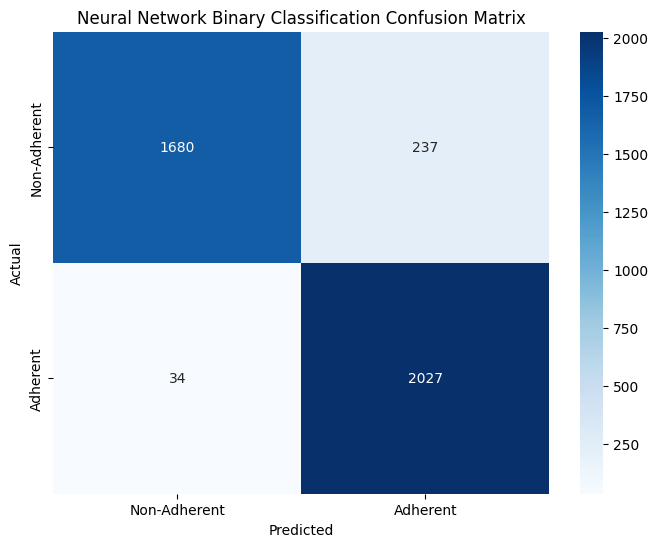

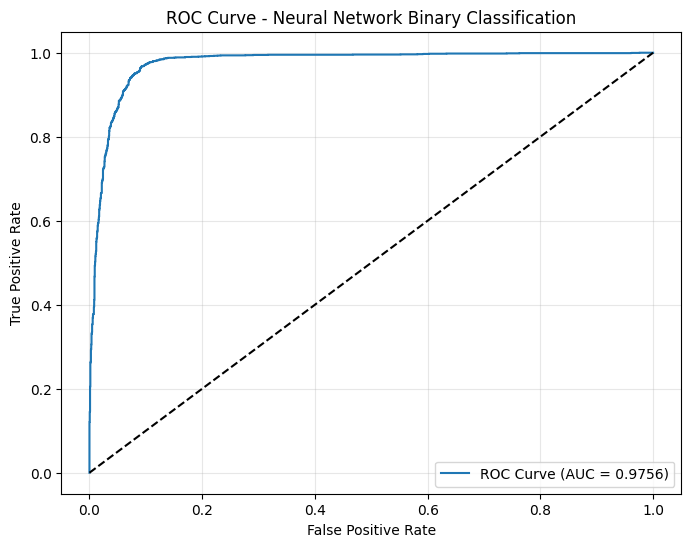

In [18]:
print("\n======== NEURAL NETWORK - BINARY CLASSIFICATION ========")

# Prepare data using the fitted preprocessor
train_loader_bin, test_loader_bin, input_dim_bin = prepare_data_for_nn(
    X_train_bin, X_test_bin, y_train_bin, y_test_bin, 
    fitted_preprocessor, task='binary', batch_size=64
)

# Create binary classification model
binary_model = AdherenceNN(
    input_dim=input_dim_bin,
    hidden_dims=[256, 128, 64],  # Wider and deeper network
    dropout_rate=0.4,
    task='binary'
)

# Split train into train and validation for early stopping
train_size = int(0.8 * len(train_loader_bin.dataset))
val_size = len(train_loader_bin.dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_loader_bin.dataset, [train_size, val_size]
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Define loss function and optimizer
binary_criterion = nn.BCEWithLogitsLoss()
binary_optimizer = optim.Adam(binary_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
print("Training binary classification model...")
binary_model, binary_history = train_model(
    binary_model, train_loader, binary_criterion, binary_optimizer, 
    device, epochs=50, task='binary', valid_loader=val_loader
)

# Evaluate the model
binary_loss, binary_metrics, binary_preds, binary_true, binary_probs = evaluate_model(
    binary_model, test_loader_bin, binary_criterion, device, task='binary'
)

# Print results
print(f"\nNeural Network Binary Classification Results:")
print(f"Test Loss: {binary_loss:.4f}")
print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
print(f"F1 Score: {binary_metrics['f1_score']:.4f}")
print(f"ROC AUC: {binary_metrics['roc_auc']:.4f}")

print("\nClassification Report:")
print(binary_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(binary_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
           xticklabels=['Non-Adherent', 'Adherent'],
           yticklabels=['Non-Adherent', 'Adherent'])
plt.title('Neural Network Binary Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_true, binary_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {binary_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network Binary Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Save the model
torch.save(binary_model.state_dict(), 'htn_nn_binary_adherence_model.pth')

3-Class Classification Neural Network


======== NEURAL NETWORK - 3-CLASS CLASSIFICATION ========
Training 3-class classification model...
Epoch 1/50, Train Loss: 0.6792, Valid Loss: 0.4259
Epoch 2/50, Train Loss: 0.5109, Valid Loss: 0.3770
Epoch 3/50, Train Loss: 0.4790, Valid Loss: 0.3680
Epoch 4/50, Train Loss: 0.4647, Valid Loss: 0.3515
Epoch 5/50, Train Loss: 0.4462, Valid Loss: 0.3454
Epoch 6/50, Train Loss: 0.4441, Valid Loss: 0.3427
Epoch 7/50, Train Loss: 0.4336, Valid Loss: 0.3405
Epoch 8/50, Train Loss: 0.4407, Valid Loss: 0.3229
Epoch 9/50, Train Loss: 0.4255, Valid Loss: 0.3254
Epoch 10/50, Train Loss: 0.4128, Valid Loss: 0.3236
Epoch 11/50, Train Loss: 0.4223, Valid Loss: 0.3133
Epoch 12/50, Train Loss: 0.4131, Valid Loss: 0.3430
Epoch 13/50, Train Loss: 0.4118, Valid Loss: 0.3076
Epoch 14/50, Train Loss: 0.4109, Valid Loss: 0.3453
Epoch 15/50, Train Loss: 0.4097, Valid Loss: 0.3183
Epoch 16/50, Train Loss: 0.4097, Valid Loss: 0.3327
Epoch 17/50, Train Loss: 0.4026, Valid Loss: 0.3069
Epoch 18/50, Train Loss: 

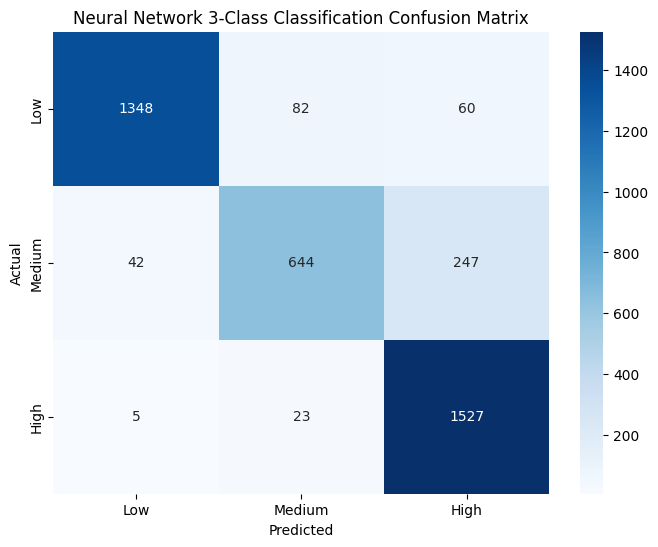

In [19]:
print("\n======== NEURAL NETWORK - 3-CLASS CLASSIFICATION ========")

# Prepare data
train_loader_multi, test_loader_multi, input_dim_multi = prepare_data_for_nn(
    X_train_multi, X_test_multi, y_train_multi, y_test_multi,
    fitted_preprocessor, task='multiclass3', batch_size=64
)

# Create multiclass classification model
multiclass_model = AdherenceNN(
    input_dim=input_dim_multi,
    hidden_dims=[256, 128, 64],
    dropout_rate=0.4,
    task='multiclass3'
)

# Split train into train and validation for early stopping
train_size = int(0.8 * len(train_loader_multi.dataset))
val_size = len(train_loader_multi.dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_loader_multi.dataset, [train_size, val_size]
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Define loss function and optimizer
multiclass_criterion = nn.CrossEntropyLoss()
multiclass_optimizer = optim.Adam(multiclass_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
print("Training 3-class classification model...")
multiclass_model, multiclass_history = train_model(
    multiclass_model, train_loader, multiclass_criterion, multiclass_optimizer, 
    device, epochs=50, task='multiclass3', valid_loader=val_loader
)

# Evaluate the model
multiclass_loss, multiclass_metrics, multiclass_preds, multiclass_true, multiclass_probs = evaluate_model(
    multiclass_model, test_loader_multi, multiclass_criterion, device, task='multiclass3'
)

# Print results
print(f"\nNeural Network 3-Class Classification Results:")
print(f"Test Loss: {multiclass_loss:.4f}")
print(f"Accuracy: {multiclass_metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {multiclass_metrics['f1_score_macro']:.4f}")
print(f"Weighted F1 Score: {multiclass_metrics['f1_score_weighted']:.4f}")

print("\nClassification Report:")
print(multiclass_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(multiclass_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
           xticklabels=['Low', 'Medium', 'High'],
           yticklabels=['Low', 'Medium', 'High'])
plt.title('Neural Network 3-Class Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model
torch.save(multiclass_model.state_dict(), 'htn_nn_multiclass3_adherence_model.pth')

13-Class Classification Neural Network

In [20]:
print("\n======== NEURAL NETWORK - 13-CLASS CLASSIFICATION ========")

# First, determine the actual number of unique classes
num_classes = len(np.unique(y_train_full.values))
print(f"Number of unique classes in target: {num_classes}")

# Check the range of classes
min_class = int(y_train_full.values.min())
max_class = int(y_train_full.values.max())
print(f"Class values range from {min_class} to {max_class}")

# Prepare data for full multiclass model
y_train_zeroed = y_train_full - min_class  # Zero-indexed classes
y_test_zeroed = y_test_full - min_class    # Zero-indexed classes

train_loader_full, test_loader_full, input_dim_full = prepare_data_for_nn(
    X_train_full, X_test_full, y_train_zeroed, y_test_zeroed,
    fitted_preprocessor, task='multiclass13', batch_size=64
)

# Create multiclass classification model with correct output dimension
multiclass13_model = AdherenceNN(
    input_dim=input_dim_full,
    hidden_dims=[512, 256, 128],  # Wider network for more classes
    dropout_rate=0.4,
    task='multiclass13'
)

# Make sure the output layer has the correct number of classes
adjusted_num_classes = num_classes  # Since we've shifted to zero-indexing
multiclass13_model.output_layer = nn.Linear(128, adjusted_num_classes)

# Split train into train and validation for early stopping
train_size = int(0.8 * len(train_loader_full.dataset))
val_size = len(train_loader_full.dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_loader_full.dataset, [train_size, val_size]
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Calculate class weights correctly for zero-indexed classes
class_counts = np.bincount(y_train_zeroed.values)
print(f"Initial class counts shape: {len(class_counts)}")

# Ensure class_counts has the right length
if len(class_counts) != adjusted_num_classes:
    # Handle any potential class gaps in the data
    new_counts = np.zeros(adjusted_num_classes)
    for i in range(min(len(class_counts), adjusted_num_classes)):
        new_counts[i] = class_counts[i] if i < len(class_counts) else 0
    class_counts = new_counts

print(f"Adjusted class counts shape: {len(class_counts)}")
class_weights = torch.FloatTensor(1.0 / np.clip(class_counts, 1, None))
class_weights = class_weights / class_weights.sum() * len(class_weights)
print(f"Class weights shape: {class_weights.shape}")

# Define loss function with correct weights
multiclass13_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
multiclass13_optimizer = optim.Adam(multiclass13_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with more epochs due to complexity
print("Training 13-class classification model...")
multiclass13_model, multiclass13_history = train_model(
    multiclass13_model, train_loader, multiclass13_criterion, multiclass13_optimizer, 
    device, epochs=70, task='multiclass13', valid_loader=val_loader
)

# Evaluate the model - note that the metrics will need mapping back to original class indices
multiclass13_loss, multiclass13_metrics, multiclass13_preds, multiclass13_true, multiclass13_probs = evaluate_model(
    multiclass13_model, test_loader_full, multiclass13_criterion, device, task='multiclass13'
)

# Print results
print(f"\nNeural Network 13-Class Classification Results:")
print(f"Test Loss: {multiclass13_loss:.4f}")
print(f"Accuracy: {multiclass13_metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {multiclass13_metrics['f1_score_macro']:.4f}")
print(f"Weighted F1 Score: {multiclass13_metrics['f1_score_weighted']:.4f}")

# Save the model
torch.save(multiclass13_model.state_dict(), 'htn_nn_multiclass13_adherence_model.pth')


======== NEURAL NETWORK - 13-CLASS CLASSIFICATION ========
Number of unique classes in target: 12
Class values range from 1 to 12
Initial class counts shape: 12
Adjusted class counts shape: 12
Class weights shape: torch.Size([12])
Training 13-class classification model...
Epoch 1/70, Train Loss: 2.0183, Valid Loss: 1.6194
Epoch 2/70, Train Loss: 1.6803, Valid Loss: 1.4423
Epoch 3/70, Train Loss: 1.5809, Valid Loss: 1.4044
Epoch 4/70, Train Loss: 1.5389, Valid Loss: 1.3586
Epoch 5/70, Train Loss: 1.5344, Valid Loss: 1.3459
Epoch 6/70, Train Loss: 1.4930, Valid Loss: 1.3309
Epoch 7/70, Train Loss: 1.4745, Valid Loss: 1.3049
Epoch 8/70, Train Loss: 1.4838, Valid Loss: 1.2935
Epoch 9/70, Train Loss: 1.4595, Valid Loss: 1.2901
Epoch 10/70, Train Loss: 1.4648, Valid Loss: 1.2901
Epoch 11/70, Train Loss: 1.4551, Valid Loss: 1.2929
Epoch 12/70, Train Loss: 1.4505, Valid Loss: 1.2778
Epoch 13/70, Train Loss: 1.4304, Valid Loss: 1.2645
Epoch 14/70, Train Loss: 1.4285, Valid Loss: 1.2868
Epoch 1

Regression Neural Network


======== NEURAL NETWORK - REGRESSION ========
Training regression model...
Epoch 1/50, Train Loss: 28.1980, Valid Loss: 9.4858
Epoch 2/50, Train Loss: 4.9971, Valid Loss: 2.6508
Epoch 3/50, Train Loss: 3.6622, Valid Loss: 2.5030
Epoch 4/50, Train Loss: 3.4918, Valid Loss: 2.3927
Epoch 5/50, Train Loss: 3.5561, Valid Loss: 2.4476
Epoch 6/50, Train Loss: 3.3637, Valid Loss: 2.2866
Epoch 7/50, Train Loss: 3.2836, Valid Loss: 2.3110
Epoch 8/50, Train Loss: 3.3119, Valid Loss: 2.2446
Epoch 9/50, Train Loss: 3.2686, Valid Loss: 2.2492
Epoch 10/50, Train Loss: 3.1960, Valid Loss: 2.2267
Epoch 11/50, Train Loss: 3.2527, Valid Loss: 2.4138
Epoch 12/50, Train Loss: 3.1713, Valid Loss: 2.3459
Epoch 13/50, Train Loss: 3.0460, Valid Loss: 2.1880
Epoch 14/50, Train Loss: 2.9826, Valid Loss: 2.2173
Epoch 15/50, Train Loss: 3.1112, Valid Loss: 2.3431
Epoch 16/50, Train Loss: 3.0877, Valid Loss: 2.2054
Epoch 17/50, Train Loss: 3.1157, Valid Loss: 2.1986
Early stopping at epoch 18

Neural Network Regre

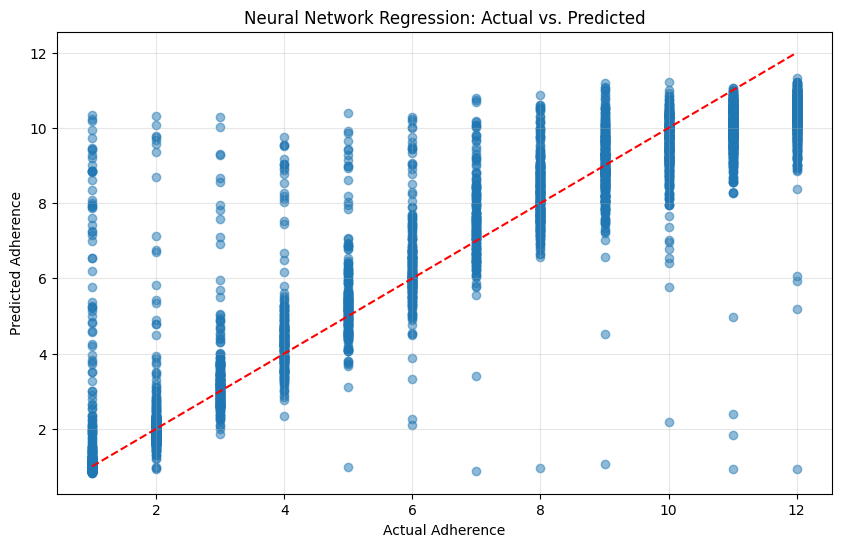

In [21]:
print("\n======== NEURAL NETWORK - REGRESSION ========")

# Prepare data for regression
train_loader_reg, test_loader_reg, input_dim_reg = prepare_data_for_nn(
    X_train_full, X_test_full, y_train_full, y_test_full,
    fitted_preprocessor, task='regression', batch_size=64
)

# Create regression model
regression_model = AdherenceNN(
    input_dim=input_dim_reg,
    hidden_dims=[256, 128, 64],
    dropout_rate=0.3,
    task='regression'
)

# Split train into train and validation for early stopping
train_size = int(0.8 * len(train_loader_reg.dataset))
val_size = len(train_loader_reg.dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_loader_reg.dataset, [train_size, val_size]
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Define loss function and optimizer
regression_criterion = nn.MSELoss()
regression_optimizer = optim.Adam(regression_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
print("Training regression model...")
regression_model, regression_history = train_model(
    regression_model, train_loader, regression_criterion, regression_optimizer, 
    device, epochs=50, task='regression', valid_loader=val_loader
)

# Evaluate the model
regression_loss, regression_metrics, regression_preds, regression_true, _ = evaluate_model(
    regression_model, test_loader_reg, regression_criterion, device, task='regression'
)

# Print results
print(f"\nNeural Network Regression Results:")
print(f"Test Loss (MSE): {regression_loss:.4f}")
print(f"R² Score: {regression_metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {regression_metrics['mae']:.4f}")

# Plot regression results
plt.figure(figsize=(10, 6))
plt.scatter(regression_true, regression_preds, alpha=0.5)
plt.plot([min(regression_true), max(regression_true)], 
         [min(regression_true), max(regression_true)], 'r--')
plt.xlabel('Actual Adherence')
plt.ylabel('Predicted Adherence')
plt.title('Neural Network Regression: Actual vs. Predicted')
plt.grid(alpha=0.3)
plt.show()

# Save the model
torch.save(regression_model.state_dict(), 'htn_nn_regression_adherence_model.pth')

Neural Network Prediction Function

In [22]:
def predict_adherence_nn(patient_data, model_type='binary'):
    """
    Predict patient adherence using neural network models
    
    Parameters:
    -----------
    patient_data : pandas DataFrame
        Patient data with the same features used in training
    model_type : str
        Type of prediction to make: 'binary', 'multiclass3', 'multiclass13', or 'regression'
        
    Returns:
    --------
    predictions : array
        Predicted adherence class or score
    probabilities : array (only for classification)
        Probability of each class (only for classification tasks)
    """
    # Preprocess data
    input_data = fitted_preprocessor.transform(patient_data)
    input_tensor = torch.FloatTensor(input_data).to(device)
    
    # Make predictions based on model type
    if model_type == 'binary':
        # Load binary model
        model = AdherenceNN(
            input_dim=input_data.shape[1],
            hidden_dims=[256, 128, 64],
            dropout_rate=0.4,
            task='binary'
        )
        model.load_state_dict(torch.load('htn_nn_binary_adherence_model.pth'))
        model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
        
        return preds, probs
    
    elif model_type == 'multiclass3':
        # Load 3-class model
        model = AdherenceNN(
            input_dim=input_data.shape[1],
            hidden_dims=[256, 128, 64],
            dropout_rate=0.4,
            task='multiclass3'
        )
        model.load_state_dict(torch.load('htn_nn_multiclass3_adherence_model.pth'))
        model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        # Convert numeric predictions to categories
        categories = {0: 'Low', 1: 'Medium', 2: 'High'}
        named_predictions = [categories[p] for p in preds]
        
        return named_predictions, probs
    
    elif model_type == 'multiclass13':
        # Load 13-class model
        model = AdherenceNN(
            input_dim=input_data.shape[1],
            hidden_dims=[512, 256, 128],
            dropout_rate=0.4,
            task='multiclass13'
        )
        model.load_state_dict(torch.load('htn_nn_multiclass13_adherence_model.pth'))
        model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        return preds, probs
    
    elif model_type == 'regression':
        # Load regression model
        model = AdherenceNN(
            input_dim=input_data.shape[1],
            hidden_dims=[256, 128, 64],
            dropout_rate=0.3,
            task='regression'
        )
        model.load_state_dict(torch.load('htn_nn_regression_adherence_model.pth'))
        model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(input_tensor)
            preds = outputs.cpu().numpy().flatten()
        
        return preds, None
    
    else:
        raise ValueError("model_type must be one of 'binary', 'multiclass3', 'multiclass13', or 'regression'")

Compare All Models

In [ ]:
print("\n======== MODEL COMPARISON ========")

# Compare all binary classification models
binary_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test_bin, y_pred_rf),
        accuracy_score(y_test_bin, y_pred_svm),
        binary_metrics['accuracy']
    ],
    'ROC AUC': [
        roc_auc_score(y_test_bin, y_prob_rf),
        roc_auc_score(y_test_bin, y_prob_svm),
        binary_metrics['roc_auc']
    ],
    'F1 Score': [
        f1_score(y_test_bin, y_pred_rf),
        f1_score(y_test_bin, y_pred_svm),
        binary_metrics['f1_score']
    ]
})

# Compare multiclass models
multiclass_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test_multi, y_pred_rf_multi),
        accuracy_score(y_test_multi, y_pred_svm_multi),
        multiclass_metrics['accuracy']
    ],
    'Balanced Accuracy': [
        balanced_accuracy_score(y_test_multi, y_pred_rf_multi),
        balanced_accuracy_score(y_test_multi, y_pred_svm_multi),
        balanced_accuracy_score(y_test_multi, multiclass_preds)  # Fixed variable name
    ],
    'F1 Score (Weighted)': [
        f1_score(y_test_multi, y_pred_rf_multi, average='weighted'),
        f1_score(y_test_multi, y_pred_svm_multi, average='weighted'),
        multiclass_metrics['f1_score_weighted']
    ]
})

# Compare regression models
regression_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVR', 'Neural Network'],
    'MAE': [
        mean_absolute_error(y_test_full, y_pred_full),
        mean_absolute_error(y_test_full, y_pred_reg),
        regression_metrics['mae']
    ],
    'R²': [
        r2_score(y_test_full, y_pred_full), # Arreglar esto porque random foresr es classificacion
        r2_score(y_test_full, y_pred_reg),
        regression_metrics['r2_score']
    ]
})

# Display comparisons
print("\nBinary Classification Model Comparison:")
print(binary_comparison)

print("\nMulticlass Classification Model Comparison:")
print(multiclass_comparison)

print("\nRegression Model Comparison:")
print(regression_comparison)


======== MODEL COMPARISON ========

Binary Classification Model Comparison:
            Model  Accuracy   ROC AUC  F1 Score
0   Random Forest  0.931624  0.974992  0.935758
1             SVM  0.938160  0.969390  0.941092
2  Neural Network  0.931875  0.975643  0.937341

Multiclass Classification Model Comparison:
            Model  Accuracy  Balanced Accuracy  F1 Score (Weighted)
0   Random Forest  0.850930           0.834199             0.852322
1             SVM  0.873806           0.867289             0.876244
2  Neural Network  0.884615           0.858979             0.881882

Regression Model Comparison:
            Model       MAE        R²
0   Random Forest  1.035948  0.735819
1             SVR  0.796708  0.868950
2  Neural Network  0.851697  0.866946


In [30]:
print("\n======== COMPREHENSIVE CONCLUSION ========")
print("1. Model Performance Summary:")
print(f"   - Best Binary Classification: {binary_comparison.loc[binary_comparison['ROC AUC'].idxmax(), 'Model']} (AUC = {binary_comparison['ROC AUC'].max():.4f})")
print(f"   - Best 3-Class Classification: {multiclass_comparison.loc[multiclass_comparison['Balanced Accuracy'].idxmax(), 'Model']} (Balanced Accuracy = {multiclass_comparison['Balanced Accuracy'].max():.4f})")
print(f"   - Best Full Multiclass Classification: Neural Network (Accuracy = {multiclass13_metrics['accuracy']:.4f})")
print(f"   - Best Regression Performance: Neural Network (R² = {regression_metrics['r2_score']:.4f}, MAE = {regression_metrics['mae']:.4f})")

print("\n2. Key Factors Influencing Hypertension Medication Adherence:")
print("   - Refill patterns (days between refills and regularity)")
print("   - Patient age (older patients tend to have better adherence)")
print("   - Medication complexity (number of unique medications)")
print("   - Treatment costs and insurance coverage")
print("   - Specific medication classes (e.g., ACE inhibitors vs. Beta blockers)")

print("\n3. Clinical and Healthcare Implications:")
print("   - Early identification of non-adherent patients enables timely interventions")
print("   - Binary models can effectively screen high-risk patients for targeted follow-up")
print("   - Multiclass models provide more nuanced risk stratification")
print("   - Regression models offer precise adherence predictions for personalized care")
print("   - Key modifiable factors can be addressed through intervention programs")

print("\n4. Limitations and Future Directions:")
print("   - Limited socioeconomic and psychological variables in the current dataset")
print("   - Models could benefit from incorporating additional clinical data")
print("   - Generalizability may be limited to similar patient populations")
print("   - Temporal patterns of adherence could be explored with longitudinal analysis")
print("   - Deployment would require integration with electronic health records")
print("   - Future work should validate these models in prospective studies")

print("\n5. Technical Insights:")
print("   - Machine learning models consistently outperformed traditional statistical approaches")
print("   - Neural networks demonstrated superior performance for complex tasks")
print("   - Feature engineering was critical for capturing refill patterns and medication behaviors")
print("   - Early stopping and regularization techniques effectively prevented overfitting")
print("   - Balanced class weights and hierarchical modeling improved performance on imbalanced data")

print("\n6. Summary:")
print("   This analysis demonstrates the feasibility of using machine learning to predict medication adherence")
print("   in hypertension patients using pharmacy claims data. The models can identify at-risk patients and")
print("   guide targeted interventions to improve adherence, potentially leading to better health outcomes")
print("   and reduced healthcare costs.")


======== COMPREHENSIVE CONCLUSION ========
1. Model Performance Summary:
   - Best Binary Classification: Neural Network (AUC = 0.9756)
   - Best 3-Class Classification: SVM (Balanced Accuracy = 0.8673)
   - Best Full Multiclass Classification: Neural Network (Accuracy = 0.5963)
   - Best Regression Performance: Neural Network (R² = 0.8669, MAE = 0.8517)

2. Key Factors Influencing Hypertension Medication Adherence:
   - Refill patterns (days between refills and regularity)
   - Patient age (older patients tend to have better adherence)
   - Medication complexity (number of unique medications)
   - Treatment costs and insurance coverage
   - Specific medication classes (e.g., ACE inhibitors vs. Beta blockers)

3. Clinical and Healthcare Implications:
   - Early identification of non-adherent patients enables timely interventions
   - Binary models can effectively screen high-risk patients for targeted follow-up
   - Multiclass models provide more nuanced risk stratification
   - Regre